In [88]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler

# Librerías adicionales
import itertools  # Para generar combinaciones de columnas
import matplotlib.patches as mpatches  # Para manejar gráficos

# Importación de módulo personalizado
import payments_manager as pm

# Inicialización del proyecto (si es necesario)
# pm.help()  # Si se necesita ayuda del módulo
# pm.reset()  # Para reiniciar cualquier configuración anterior
# pm.init()  # Si es necesario inicializar el módulo con opciones (por ejemplo, debug=True)

# Cargar y preparar el DataFrame df_jo
df_jo = pm.df('df_jo')  # Cargar el DataFrame desde 'payments_manager'
df_jo.info()  # Ver información básica sobre el DataFrame

# Ordenar el DataFrame df_jo por la columna 'id_cr' y resetear índices
df_jo = df_jo.sort_values(by=["id_cr"]).reset_index(drop=True)

# Crear una copia del DataFrame para su posterior uso
df_jo_cp = df_jo.copy()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

In [89]:
# PASAJE DE CATEGORICAS A NUMERICAS

# Reasignar valores en la columna 'transfer_type'
df_jo_cp['transfer_type'] = df_jo_cp['transfer_type'].map({'regular': 0, 'instant': 1})
df_jo_cp['charge_moment'] = df_jo_cp['charge_moment'].map({'before': 0, 'after': 1})

In [90]:
# SEGMENTACIONES EN DATAFRAMES REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)
user_action_counts = df_jo_cp_sorted['user_id'].value_counts()
repeat_users_ids = user_action_counts[user_action_counts > 1].index
new_users_ids = user_action_counts[user_action_counts == 1].index

# Obtener los usuarios nuevos (aquellos con solo una acción)
new_users_df = df_jo_cp_sorted[df_jo_cp_sorted['user_id'].isin(new_users_ids)]

# Obtener la primera acción de cada usuario nuevo (ya que todos tienen solo una acción)
new_users_df = new_users_df.groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Filtrar los usuarios repetitivos (aquellos con más de una acción)
repeat_users_df = df_jo_cp_sorted[df_jo_cp_sorted['user_id'].isin(repeat_users_ids)]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')



Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 5782
Número de filas en el DataFrame de usuarios repetitivos: 26310


In [91]:
#VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 36.77 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 55.73 %


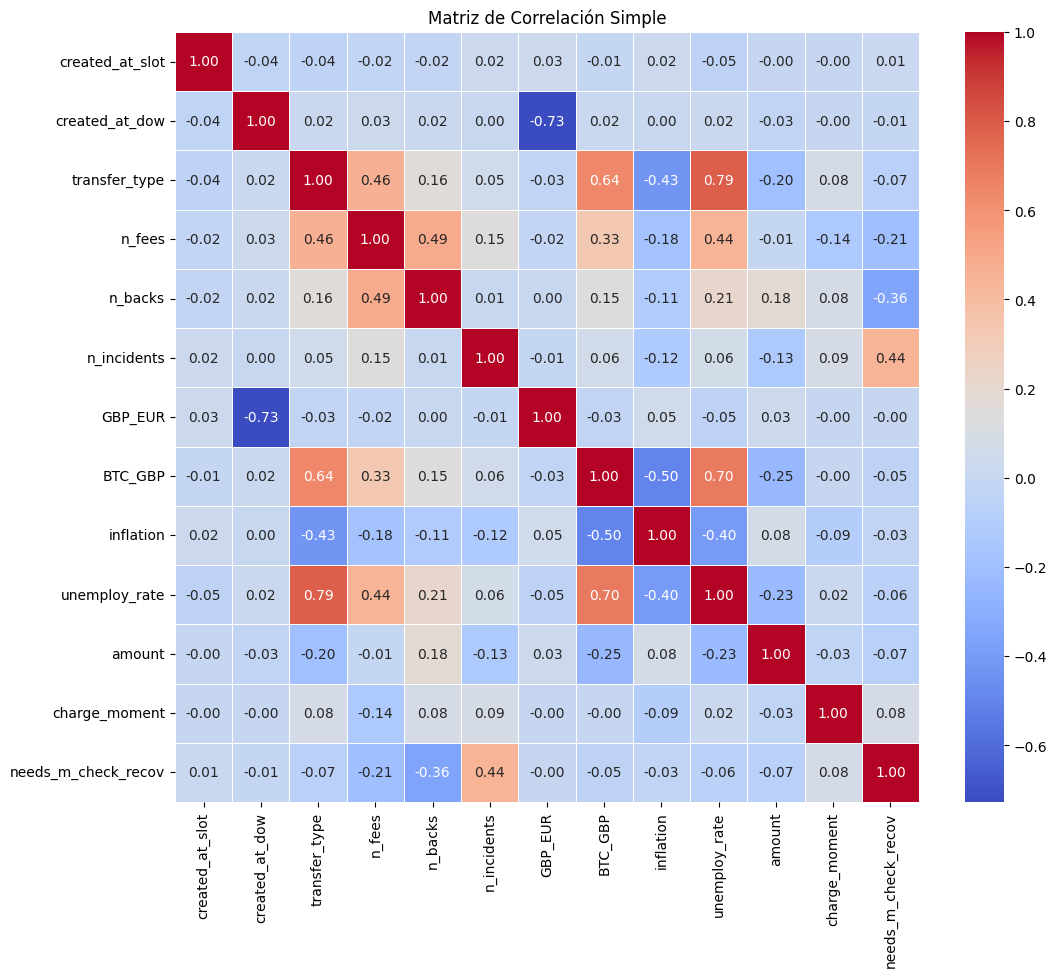

In [92]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment','needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
#df_simpl = df_jo_cp_sorted[columnas_deseadas]
#df_simpl = new_users_df[columnas_deseadas]
df_simpl = repeat_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [93]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 12)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)

needs_m_check_recov
0    11648
1    11648
Name: count, dtype: int64


In [94]:
# NORMALIZACION Y ESCALADO

# Eliminar las columnas no necesarias del DataFrame
X_s = balanced_df.drop(columns=[
    'needs_m_check_recov',
])

# Definir la variable objetivo
Y_s = balanced_df['needs_m_check_recov']

# Aplicar StandardScaler para la normalización
s_scaler = StandardScaler()
X_s_scaled = s_scaler.fit_transform(X_s)

# Convertir el array escalado de nuevo a DataFrame y restaurar los nombres de las columnas
X_s_scaled = pd.DataFrame(X_s_scaled, columns=X_s.columns)

# Imprimir las formas de los datos
print(X_s_scaled.shape)
print(Y_s.shape)

(23296, 12)
(23296,)


In [95]:
# PREPARACION DE CARACTERISTICAS Y ETIQUETA PARA MODELOS

# Crea la matriz de características y la var objetivo
X = X_s.drop(columns=[
    #'needs_m_check_recov',  
    # 'created_at_slot',      
    'created_at_dow',       
    'transfer_type',
    # 'n_fees',
    # 'n_backs',
    # 'n_incidents',
    # 'GBP_EUR',
    # 'BTC_GBP',
    'inflation',      
    'unemploy_rate',
    'amount',
])

y = Y_s  # La columna de la variable objetivo

print(X.shape)
print(y.shape)


(23296, 7)
(23296,)


In [96]:
# MODELO DE ÁRBOL DE DECISIÓN

# Dividir el dataset en entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Árbol de Decisión
DT = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=3)

# Entrenar el modelo con el conjunto de datos de entrenamiento
DT.fit(train_X, train_y)

# Realizar predicciones sobre el conjunto de prueba
predictions = DT.predict(test_X)



Precisión del modelo: 0.8620

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86      2326
           1       0.84      0.90      0.87      2334

    accuracy                           0.86      4660
   macro avg       0.86      0.86      0.86      4660
weighted avg       0.86      0.86      0.86      4660


Importancia de las características (ordenadas por magnitud):
n_incidents: 0.8781
n_backs: 0.1219
created_at_slot: 0.0000
n_fees: 0.0000
GBP_EUR: 0.0000
BTC_GBP: 0.0000
charge_moment: 0.0000


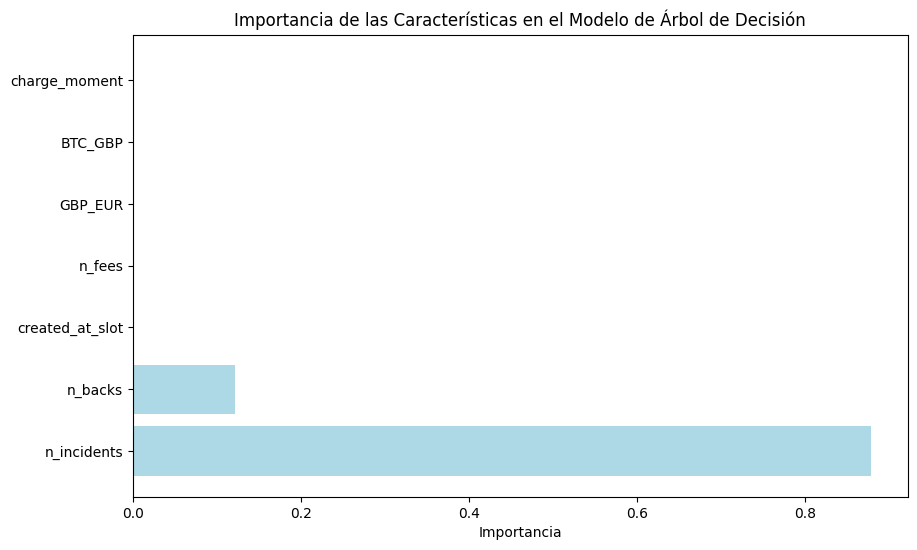

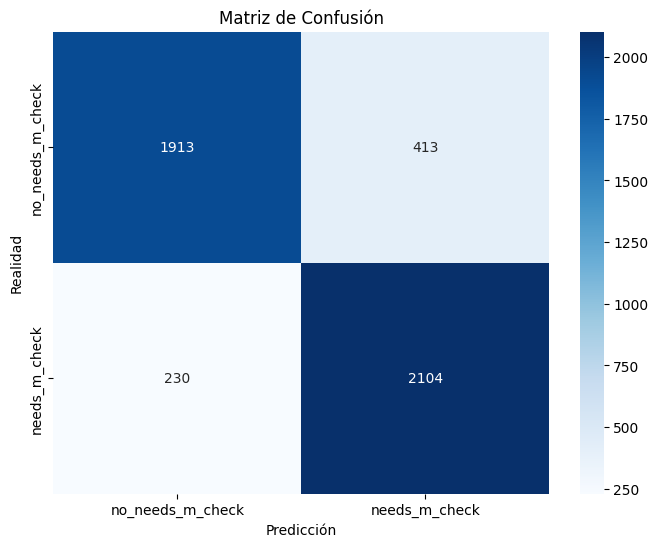

In [97]:
# EVALUACION DEL RENDIMIENTO DEL MODELO

# 1. Precisión del modelo
accuracy = DT.score(test_X, test_y)
print(f"Precisión del modelo: {accuracy:.4f}")  # Precisión en el conjunto de prueba

# 2. Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(test_y, predictions))  
# Muestra el reporte con métricas como precisión, recall, f1-score para cada clase

# 3. Importancia de las características

# Extraer los nombres de las características
feature_names = X.columns

# Obtener las importancias de las características del modelo
feature_importances = DT.feature_importances_

# Crear una lista de tuplas con el nombre de la característica y su importancia
feature_importance = list(zip(feature_names, feature_importances))

# Ordenar las características por la importancia en orden descendente
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Imprimir las características ordenadas por importancia
print("\nImportancia de las características (ordenadas por magnitud):")
for feature, importance in feature_importance_sorted:
    print(f"{feature}: {importance:.4f}")

# 4. Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
# Graficar las importancias de las características (ordenadas)
features = [f[0] for f in feature_importance_sorted]
importances = [f[1] for f in feature_importance_sorted]

# Crear el gráfico de barras
plt.barh(features, importances, color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.show()

# 5. Matriz de confusión

# Nombres de las clases para la matriz de confusión
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 = No, 1 = Sí

# Visualización de la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', 
            xticklabels=columnas, yticklabels=columnas)

# Personalización de los ejes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()


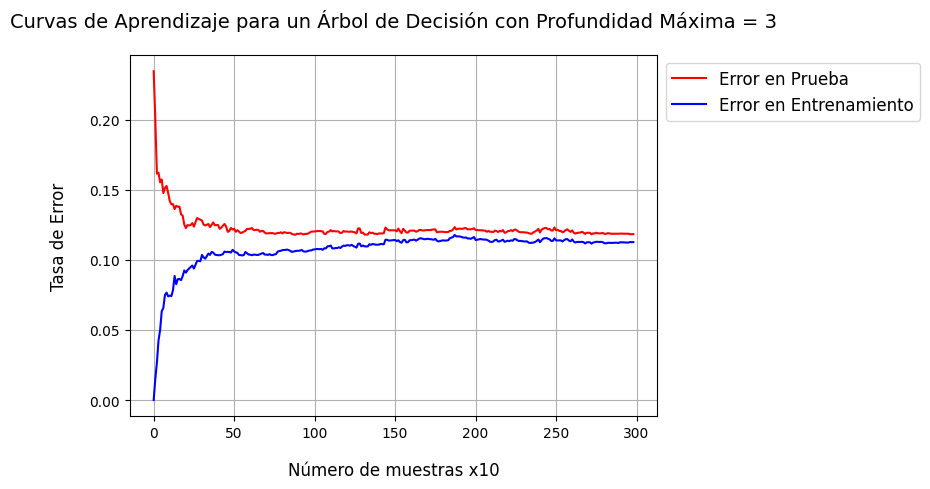

In [98]:

%matplotlib inline

# Importar las bibliotecas necesarias
import numpy as np  # Para operaciones numéricas
import matplotlib.pyplot as plt  # Para graficar gráficos
from sklearn import metrics  # Para calcular métricas de rendimiento del modelo
from sklearn import tree  # Para utilizar modelos de árbol de decisión

# Establecer la semilla para la aleatorización (asegura resultados repetibles)
np.random.seed(42)

# Establecer la complejidad del árbol de decisión en 1 (árbol de decisión con una profundidad máxima de 1)
C = 3  # Profundidad máxima del árbol de decisión (establecido en 1)
MAXN = 1000  # Número máximo de muestras por clase

# Inicializar matrices para almacenar las tasas de error para 10 iteraciones y diferentes números de muestras de entrenamiento
yhat_test_c1 = np.zeros((10, 299, 2))  # Error en prueba (tamaño: [iteraciones, tamaños de muestra, conjunto])
yhat_train_c1 = np.zeros((10, 299, 2))  # Error en entrenamiento

# Ejecutar el experimento 10 veces para obtener curvas suavizadas promedio
for iteration in range(10):
    
    # Generar datos sintéticos para el conjunto de entrenamiento
    # Usar distribuciones normales para crear datos representativos
    train_X = np.concatenate([
        1.25 * np.random.randn(MAXN, 2),  # Primera distribución
        5 + 1.5 * np.random.randn(MAXN, 2),  # Segunda distribución
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)  # Tercera distribución
    ])
    train_y = np.concatenate([
        np.ones((MAXN, 1)),  # Etiquetas para la primera clase
        -np.ones((MAXN, 1)),  # Etiquetas para la segunda clase
        np.ones((MAXN, 1))  # Etiquetas para la tercera clase
    ])

    # Aleatorizar los datos para asegurar la variabilidad
    perm = np.random.permutation(y_train.size)
    train_X = train_X[perm, :]
    train_y = train_y[perm]

    # Generar datos sintéticos para el conjunto de prueba
    test_X = np.concatenate([
        1.25 * np.random.randn(MAXN, 2),
        5 + 1.5 * np.random.randn(MAXN, 2),
        [8, 5] + 1.5 * np.random.randn(MAXN, 2)
    ])
    test_y = np.concatenate([
        np.ones((MAXN, 1)),
        -np.ones((MAXN, 1)),
        np.ones((MAXN, 1))
    ])

    # Evaluar el modelo con diferentes tamaños de muestra
    for j, N in enumerate(range(10, 3000, 10)):
        # Tomar un subconjunto de datos para entrenamiento con los primeros N ejemplos
        X_subset = train_X[:N, :]
        y_subset = train_y[:N]

        # Crear y entrenar un clasificador de árbol de decisión con una profundidad máxima de C (ahora 1)
        clf = tree.DecisionTreeClassifier(min_samples_leaf=1, max_depth=C)
        clf.fit(X_subset, y_subset.ravel())  # Ajustar el modelo a los datos de entrenamiento

        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error
        yhat_test_c1[iteration, j, 1] = 1 - metrics.accuracy_score(clf.predict(test_X), test_y.ravel())

        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error
        yhat_train_c1[iteration, j, 1] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset.ravel())

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable
mean_test_error_c1 = np.mean(yhat_test_c1[:, :, 1].T, axis=1)
mean_train_error_c1 = np.mean(yhat_train_c1[:, :, 1].T, axis=1)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error_c1, 'r', label='Error en Prueba')  # Error en el conjunto de prueba
plt.plot(mean_train_error_c1, 'b', label='Error en Entrenamiento')  # Error en el conjunto de entrenamiento

# Configurar etiquetas, título y leyenda
plt.xlabel('Número de muestras x10', fontsize=12, labelpad=15)  # Etiqueta del eje X con espacio fuera del gráfico
plt.ylabel('Tasa de Error', fontsize=12, labelpad=15)  # Etiqueta del eje Y con espacio fuera del gráfico
plt.title('Curvas de Aprendizaje para un Árbol de Decisión con Profundidad Máxima = 3', fontsize=14, pad=20)  # Título con espacio fuera del gráfico
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))  # Mostrar la gráfica con las curvas de error
plt.grid(True)
plt.tight_layout()  # Ajustar la distribución para evitar que las etiquetas se corten
plt.show()
